## Electric Motor Temperature Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/ML_practice/project2/pmsm_temperature_data.csv')

data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


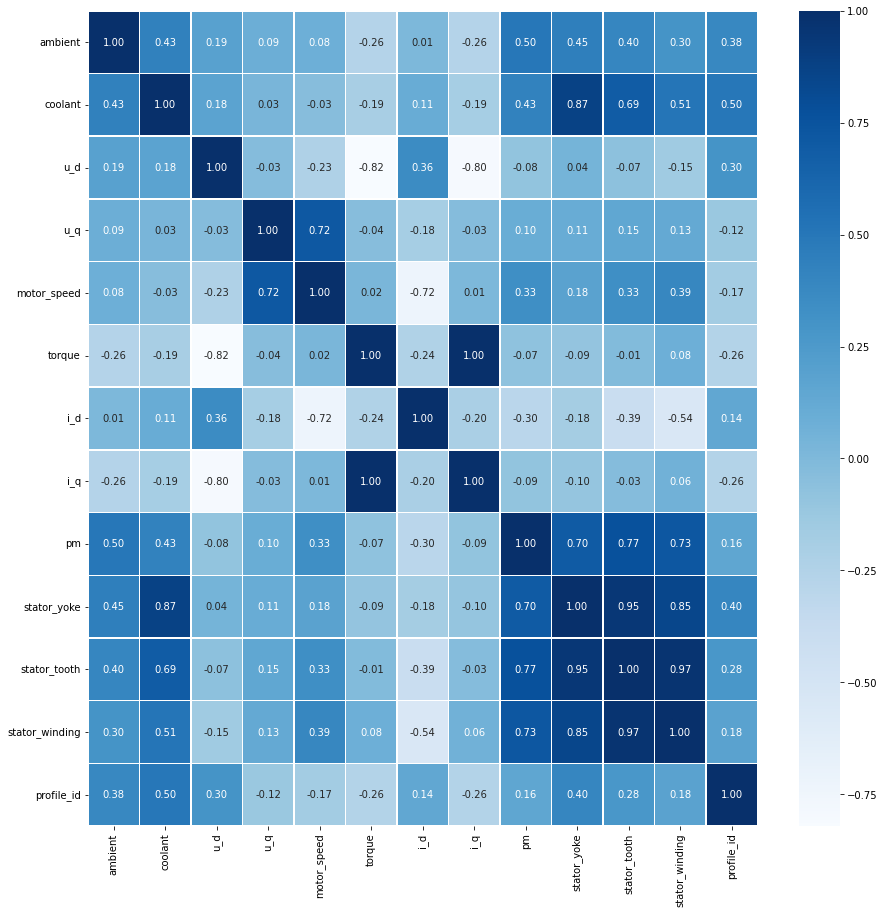

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns    
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [8]:
target = data.loc[:,["pm","stator_yoke","stator_tooth","stator_winding"]]
target

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...
998065,0.429853,1.018568,0.836084,0.494725
998066,0.429751,1.013417,0.834438,0.494279
998067,0.429439,1.002906,0.833936,0.492666
998068,0.429558,0.999157,0.830504,0.490581


In [9]:
target.corr()

,pm,stator_yoke,stator_tooth,stator_winding
pm,1.000000,0.695014,0.768352,0.729561
stator_yoke,0.695014,1.000000,0.949898,0.845144
stator_tooth,0.768352,0.949898,1.000000,0.965633
stator_winding,0.729561,0.845144,0.965633,1.000000


* torque를 제외한 pm, stator_yoke, stator_tooth, stator_widing이 높은 상관관계를 보이고 있음.

# pm~stator_winding을 PCA를 통하여 차원축소 진행.
-> torque는 단일 모델로 사용하고, PCA모델의 결과와 결합.

-> torque와 PCA의 모델은 독립적이기 때문.

In [10]:
from sklearn.decomposition import PCA

pca_target = target
pca_target.head()

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145


In [33]:
pca = PCA(n_components=4)
Xlow = pca.fit_transform(pca_target)

In [34]:
pca_target2 = pca.inverse_transform(Xlow)

In [35]:
pd.DataFrame(Xlow).head()

,0,1,2,3
0,-4.183849,0.710603,-0.043310,-0.003917
1,-4.182892,0.711435,-0.043231,-0.004637
2,-4.182157,0.712094,-0.043353,-0.004954
3,-4.181306,0.711346,-0.043639,-0.005771
4,-4.181587,0.711486,-0.043841,-0.006350


In [36]:
pd.DataFrame(pca_target2).head()

,0,1,2,3
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017344
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145


In [37]:
pca.components_

array([[ 0.45217019,  0.50401587,  0.53076494,  0.50970452],
       [-0.88599958,  0.34880767,  0.21982701,  0.21216512],
       [-0.09052286, -0.69902815,  0.06235971,  0.70659502],
       [ 0.04850236,  0.36832167, -0.81613475,  0.44261806]])

In [38]:
pca.explained_variance_ratio_

array([8.71991852e-01, 8.90531508e-02, 3.84125504e-02, 5.42446431e-04])

* 주성분의 누적기여율이 각각 0.87, 0.08, 0.03, 0.0005 이므로 첫 번째 주성분만 사용해도 무방하다고 판단. 

* 따라서 종속변수로 PCA1(= 0.45pm + 0.5stator_yoke + 0.53stator_tooth + 0.5stator_winding) 결정.

* torque의 경우 온도가 아닌 물리적인 값이므로 제외.

In [45]:
pca_R = PCA(n_components = 1)
Xlow_R = pca_R.fit_transform(pca_target)
y_pca = pd.DataFrame(Xlow_R, columns = ["y_PCA1"])
y_pca.head()

,y_PCA1
0,-4.183849
1,-4.182892
2,-4.182157
3,-4.181306
4,-4.181587


In [46]:
pd.DataFrame(pca_R.inverse_transform(Xlow_R)).head()

,0,1,2,3
0,-1.896208,-2.108117,-2.222848,-2.136462
1,-1.895775,-2.107635,-2.222340,-2.135974
2,-1.895442,-2.107264,-2.221950,-2.135599
3,-1.895058,-2.106835,-2.221498,-2.135165
4,-1.895185,-2.106977,-2.221647,-2.135308


In [47]:
target.head()

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145


# 독립변수에 대한 PCA 검증

In [48]:
x = data.loc[:,["ambient","coolant","u_d","u_q","motor_speed","i_d","i_q","profile_id"]]
x

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,-0.245860,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,-0.245832,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,-0.245818,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,-0.246955,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,-0.246610,4
...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,1.029142,-0.245722,72
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,1.029148,-0.245736,72
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,1.029191,-0.245701,72
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,1.029147,-0.245727,72


In [49]:
data1 = pd.concat([x,y_pca], axis=1)

In [50]:
data1

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,profile_id,y_PCA1
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,-0.245860,4,-4.183849
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,-0.245832,4,-4.182892
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,-0.245818,4,-4.182157
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,-0.246955,4,-4.181306
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,-0.246610,4,-4.181587
...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,1.029142,-0.245722,72,1.408526
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,1.029148,-0.245736,72,1.404783
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,1.029191,-0.245701,72,1.398256
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,1.029147,-0.245727,72,1.393536


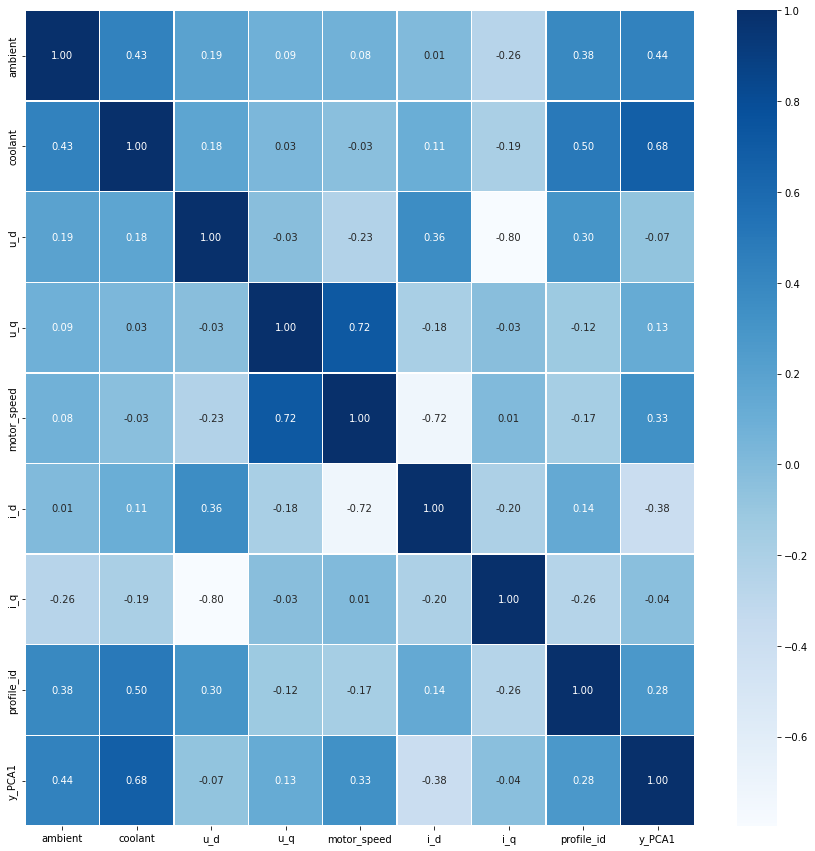

In [51]:
import matplotlib.pyplot as plt 
import seaborn as sns    
plt.figure(figsize=(15,15))
sns.heatmap(data = data1.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [52]:
torque_i = data.loc[:,["i_q","torque"]]
motor_speed_u = data.loc[:,["motor_speed","u_q"]]

In [53]:
print(torque_i.corr())
print(motor_speed_u.corr())

            i_q   torque
i_q     1.00000  0.99656
torque  0.99656  1.00000
             motor_speed       u_q
motor_speed     1.000000  0.716897
u_q             0.716897  1.000000


In [54]:
torque_i_pca = PCA(n_components = 1)
torque_i_Xlow = torque_i_pca.fit_transform(torque_i)

motor_speed_u_pca = PCA(n_components=1)
motor_speed_u_Xlow = motor_speed_u_pca.fit_transform(motor_speed_u)

In [55]:
print(torque_i_pca.explained_variance_ratio_)
print(motor_speed_u_pca.explained_variance_ratio_)

[0.99827994]
[0.85844895]


In [56]:
print(torque_i_pca.components_)
print(motor_speed_u_pca.components_)

[[-0.70710877 -0.7071048 ]]
[[0.70656461 0.70764854]]


* motor_speed와 u_q의 경우 축약해도 주성분 1개로는 충분하지 않음.   
(누적 기여율 : 0.85)
* 반면 torque와 i_q의 경우 주성분 1개로 99%의 설명력을 가짐
- 따라서 torque + i_q를 x_PCA로 축약
- motor_speed와 u_q의 경우 변수 그대로 사용

* PCA1 = -0.7 i_d -0.7 torque

In [57]:
x_pca = pd.DataFrame(torque_i_Xlow,columns = ["x_PCA"])
x_pca

,x_PCA
0,0.346140
1,0.345378
2,0.345579
3,0.345821
4,0.345622
...,...
998065,0.349901
998066,0.349911
998067,0.349887
998068,0.349905


In [58]:
torque_i_inverse=torque_i_pca.inverse_transform(torque_i_Xlow)
torque_i_inverse

array([[-0.24795233, -0.24808979],
       [-0.24741407, -0.24755153],
       [-0.24755577, -0.24769323],
       ...,
       [-0.25060185, -0.2507393 ],
       [-0.2506147 , -0.25075214],
       [-0.25061225, -0.2507497 ]])

In [59]:
motor_speed_u_Xlow

array([[-1.7736487 ],
       [-1.77352847],
       [-1.77645367],
       ...,
       [-1.73755565],
       [-1.73943466],
       [-1.73737187]])

In [60]:
motor_speed_u_inverse = motor_speed_u_pca.inverse_transform(motor_speed_u_Xlow)
motor_speed_u_inverse

array([[-1.2595329 , -1.26080963],
       [-1.25944795, -1.26072455],
       [-1.2615148 , -1.26279457],
       ...,
       [-1.23403083, -1.23526844],
       [-1.23535848, -1.23659812],
       [-1.23390098, -1.23513839]])

In [61]:
motor_speed_u

,motor_speed,u_q
0,-1.222428,-1.297858
1,-1.222429,-1.297686
2,-1.222428,-1.301822
3,-1.222430,-1.301852
4,-1.222429,-1.303118
...,...,...
998065,-1.222428,-1.246114
998066,-1.222437,-1.250655
998067,-1.222430,-1.246852
998068,-1.222432,-1.249505


* moter_speed와 u_q는 편차가 실제 값과 크진 않으나, 주성분을 2개로 쓰게 되면 차원축소의 의미가 없다.
* torque와 i_q는 차원축소의 관계가 유의미 하다. 따라서 torque와 i_q는 차원축소를 하여 분석대상으로 진행한다.

#### 변수 축소 -> torque, i_q : x_PCA
#### pm,stator_yoke, stator_tooth, stator_winding : PCA1로 결정하여 원본 데이터의 칼럼을 줄이는 작업 시행.

* 차원축소를 통해 기존의 13개 변수에서 8개 변수로 축약 가능 및 다중 공선성 최소화.

* 최종 데이터 셋으로 VIF 검정 진행.

In [62]:
total_data = data.drop(["pm","stator_yoke","stator_tooth","stator_winding","torque","i_q"],axis=1)

In [63]:
total_data = pd.concat([total_data,x_pca,y_pca],axis=1)
total_data = total_data.drop(["profile_id"],axis=1)
total_data.head()

,ambient,coolant,u_d,u_q,motor_speed,i_d,x_PCA,y_PCA1
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,1.029572,0.346140,-4.183849
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,1.029509,0.345378,-4.182892
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,1.029448,0.345579,-4.182157
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,1.032845,0.345821,-4.181306
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,1.031807,0.345622,-4.181587


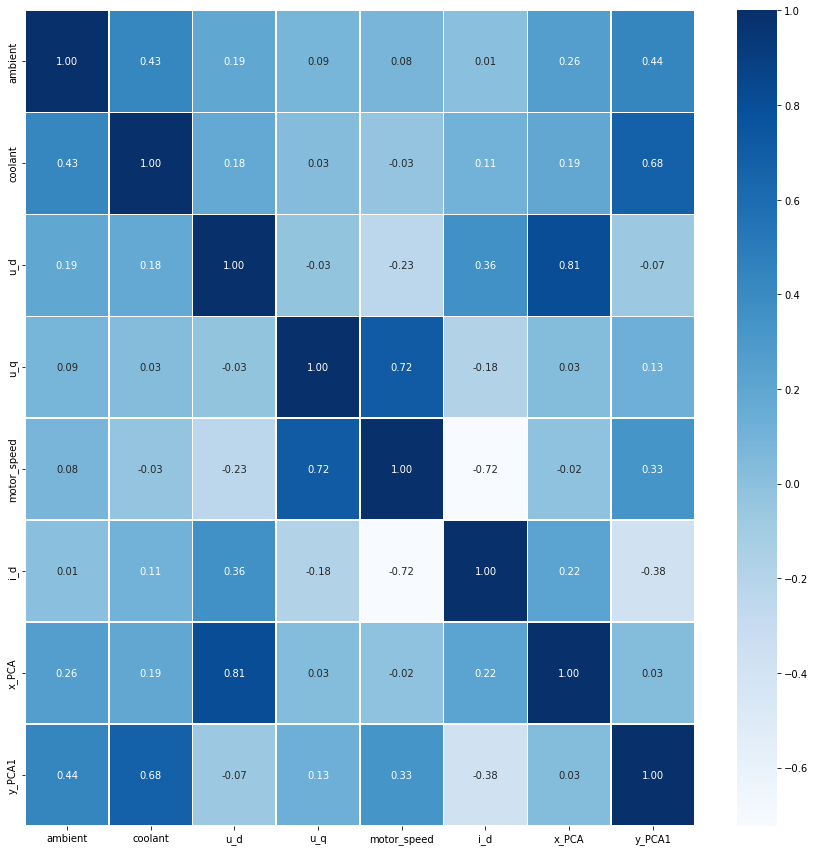

In [64]:
plt.figure(figsize=(15,15))
sns.heatmap(data = total_data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

- x_PCA와 u_d가 상관관계가 0.81로 강한모습을 보여줌
- PCA 변수 축소하기 이전에 u_d와 i_q가 강한 음의 상관관계를 보였기 때문
- linear regression 회귀분석 진행에 지장이 있을지 VIF 계수로 관찰

In [65]:
from patsy import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_y, vif_x = dmatrices('y_PCA1 ~ ambient + coolant + u_d + u_q + motor_speed + i_d + motor_speed + i_d + x_PCA',data=total_data, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_x.values, i) for i in range(vif_x.shape[1])]
vif["features"] = vif_x.columns
vif.round(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,VIF Factor,features
0,1.0,Intercept
1,1.3,ambient
2,1.3,coolant
3,3.9,u_d
4,4.8,u_q
5,10.7,motor_speed
6,5.0,i_d
7,4.0,x_PCA


- VIF 계수가 오히려 u_d보다 motor_speed에서 높게 나옴
- 하지만 VIF 계수가 15를 넘어가지 않으므로 회귀분석에 지장이 없음.

In [66]:
y = total_data.loc[:,"y_PCA1"]
x = total_data.loc[:,:"x_PCA"]
print(y.head())
print(x.head())

0   -4.183849
1   -4.182892
2   -4.182157
3   -4.181306
4   -4.181587
Name: y_PCA1, dtype: float64
    ambient   coolant       u_d       u_q  motor_speed       i_d     x_PCA
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428  1.029572  0.346140
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429  1.029509  0.345378
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428  1.029448  0.345579
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430  1.032845  0.345821
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429  1.031807  0.345622


#### Data split

In [67]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.33,random_state=123)

In [68]:
train_x

,ambient,coolant,u_d,u_q,motor_speed,i_d,x_PCA
339259,-0.220472,-0.180476,-0.403790,1.546530,0.941941,-0.112864,-0.095223
327317,-0.459517,0.377016,0.315849,-1.330556,-1.222431,1.029147,0.349897
369436,-0.139411,0.323597,1.177675,0.139803,-0.348314,0.570178,1.917082
797124,-1.022138,-0.355820,0.848799,-0.518742,-0.729976,0.473903,2.150307
498,-0.802005,-1.054030,0.183145,1.676523,2.024118,-0.818369,0.362874
...,...,...,...,...,...,...,...
192476,-1.212341,-1.076090,0.286822,-1.168538,-1.189990,0.924248,-0.320327
17730,-0.581731,-1.057742,-0.955778,0.646803,-0.140251,0.386204,-1.530400
28030,0.074134,-1.094394,0.310154,-0.707684,-0.951874,1.029142,0.349658
277869,-2.749614,-1.090646,0.167840,0.403517,-0.410789,1.013982,0.144918


In [69]:
test_x

,ambient,coolant,u_d,u_q,motor_speed,i_d,x_PCA
3111,-0.772997,-1.089701,0.182099,1.683184,2.024116,-0.752583,0.362052
799023,-1.011524,-0.419708,0.328520,-1.247393,-1.222433,1.029146,0.349892
584523,1.224529,1.242529,1.281067,1.360941,0.356871,0.650730,1.265631
877382,0.687867,1.011146,-0.805500,-0.243584,-0.525878,-0.214219,-2.441380
191182,-1.254247,-1.065719,-1.600072,-0.629632,1.282829,-1.899374,-0.916812
...,...,...,...,...,...,...,...
922450,0.371054,1.181418,0.575920,-0.285228,-0.673782,0.927992,1.034290
269749,-2.749857,-1.086847,0.224841,-0.254412,-0.735445,1.013972,0.145638
163334,-0.903968,-1.080274,-0.223364,-0.053758,-0.600171,0.703620,-0.907719
51334,2.017241,-0.166467,-1.175688,0.693532,1.483032,-1.000787,-0.468163


In [70]:
train_y

339259   -0.560281
327317   -1.505569
369436    0.500476
797124   -2.812158
498      -2.305082
            ...   
192476   -2.067085
17730    -2.270284
28030    -3.230032
277869   -2.842089
773630   -1.056901
Name: y_PCA1, Length: 668706, dtype: float64

In [71]:
test_y

3111     -0.859529
799023   -1.258588
584523    3.039521
877382    2.292146
191182    1.860084
            ...   
922450    1.394634
269749   -2.936086
163334   -2.701975
51334     2.931718
15117    -3.402462
Name: y_PCA1, Length: 329364, dtype: float64

### Linear regression

In [72]:
import statsmodels.api as sm
lm = sm.OLS(train_y,train_x)

In [73]:
model=lm.fit()

In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 y_PCA1   R-squared (uncentered):                   0.687
Model:                            OLS   Adj. R-squared (uncentered):              0.687
Method:                 Least Squares   F-statistic:                          2.098e+05
Date:                Mon, 10 Jan 2022   Prob (F-statistic):                        0.00
Time:                        05:02:43   Log-Likelihood:                     -9.7776e+05
No. Observations:              668706   AIC:                                  1.956e+06
Df Residuals:                  668699   BIC:                                  1.956e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.3034      0.001    206.817      0.000       0.301       0.306
coolant         1.2309      0.001    862.211      0.000       1.228       1.234
u_d            -0.1618      0.003    -64.375      0.000      -0.167      -0.157
u_q            -0.0041      0.003     -1.456      0.145      -0.010       0.001
motor_speed     0.0610      0.004     14.636      0.000       0.053       0.069
i_d            -0.7517      0.003   -263.702      0.000      -0.757      -0.746
x_PCA           0.0322      0.002     17.852      0.000       0.029       0.036
==============================================================================
Omnibus:                    14606.560   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20444.172
Skew:                           0.259   Prob(JB):                         0.00
Kurtosis:                       3.683   Cond. No.                         7.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

회귀분석 결과 통계적으로 무의미한 변수는 다음과 같음.
> u_q(p-value : 0.066)   

- 우려했던 motor_speed보다 PCA후 상관관계가 존재했던 u_q 변수가 탈락함을 관측.   

해당 변수를 제외하고 회귀모델에 적합한 모델이라고 판단할 수 있음.
train_x에서 u_q를 제외하고 다시 회귀모델 훈련 진행


In [75]:
import statsmodels.api as sm
lm1 = sm.OLS(train_y,train_x.drop(["u_q"],axis=1))
model=lm1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 y_PCA1   R-squared (uncentered):                   0.687
Model:                            OLS   Adj. R-squared (uncentered):              0.687
Method:                 Least Squares   F-statistic:                          2.447e+05
Date:                Mon, 10 Jan 2022   Prob (F-statistic):                        0.00
Time:                        05:02:56   Log-Likelihood:                     -9.7776e+05
No. Observations:              668706   AIC:                                  1.956e+06
Df Residuals:                  668700   BIC:                                  1.956e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.3033      0.001    206.883      0.000       0.300       0.306
coolant         1.2309      0.001    862.228      0.000       1.228       1.234
u_d            -0.1631      0.002    -69.111      0.000      -0.168      -0.158
motor_speed     0.0556      0.002     28.576      0.000       0.052       0.059
i_d            -0.7548      0.002   -386.772      0.000      -0.759      -0.751
x_PCA           0.0333      0.002     20.148      0.000       0.030       0.037
==============================================================================
Omnibus:                    14660.922   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20533.784
Skew:                           0.259   Prob(JB):                         0.00
Kurtosis:                       3.684   Cond. No.                         3.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 변수 i_q를 제거해도 모델의 R2-score나 각 변수들의 coef는 그대로인 것을 확인함.

- 따라서 기존모델로 predict 값을 산출해도 지장이 없을것이라고 예상.


In [76]:
import numpy as np
F_test = model.f_test(np.identity(6))

In [77]:
F_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[244741.3914587]]), p=0.0, df_denom=6.69e+05, df_num=6>

F 검정 확인결과 해당 회귀모델은 통계적으로 유의함을 알 수 있다. (p-value = 0 < 0.05)

In [78]:
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression(fit_intercept = True)
model_reg.fit(train_x,train_y)

LinearRegression()

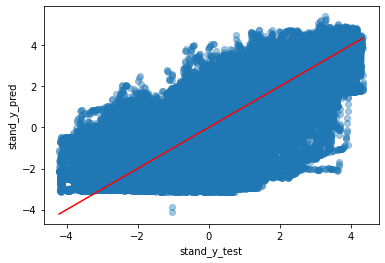

In [79]:
import numpy as np
y_predict = model_reg.predict(test_x)
plt.scatter(test_y,y_predict, alpha=0.4)
line = np.linspace(min(test_y.values), max(test_y.values), 1000)
plt.plot(line, line, color = 'r')
plt.xlabel('stand_y_test')
plt.ylabel('stand_y_pred')
plt.show()

- 산점도로 예측값과 실제값 비교분석 불가능   
- 데이터가 너무 많기 때문   
- 따라서 예측값과 실제값의 히스토그램을 통해 비교분석 진행

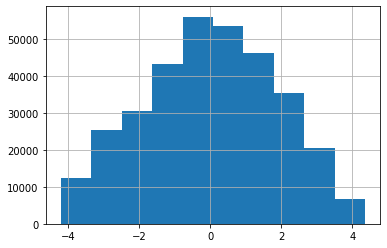

In [80]:
test_y.hist()

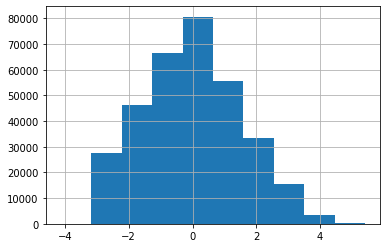

In [81]:
pd.Series(y_predict).hist()

- 예측값이 실제값에 비해 왼쪽으로 편향되있음을 관측
- r2_score가 0.68임을 감안하면 정상적으로 예측값이 출력됐음을 확인.

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(test_y, y_predict)
rmse = np.sqrt(mse)

In [83]:
print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse,rmse))

MSE : 1.090, RMSE : 1.044


In [84]:
print('Variance score : {0:.3f}'.format(r2_score(test_y,y_predict)))

Variance score : 0.685


In [85]:
print('R2 score : {0:.3f}'.format(model_reg.score(train_x, train_y)))

R2 score : 0.687


### 실험 결과
- 전처리를 통해 높은 R2 score를 가질수 있었고 예측값 또한 나쁘지 않게 생성   
- 기존의 값보다 다소 왼쪽으로 편향된 값 생성   
- 하지만 회귀식에서 변수가 높은 계수를 얻었다고 해도 회귀식 안에서만 유용하지 실제로 그 변수가 종속변수와 밀접한 관계를 가졌다고 해석하기에는 힘듬.

ex) y = 0.7x1 + 0.3x2 일때 y와 x1이 양의 관계를 가졌다고 판단하는건 회귀식 안에서만 가능.



### Decision Tree model 사용

In [86]:
from sklearn import tree
import time
start = time.time()

clf = tree.DecisionTreeRegressor()
model_clf = clf.fit(train_x,train_y)
print("Decision Tree model time : ", time.time() - start)

Decision Tree model time :  14.533489465713501


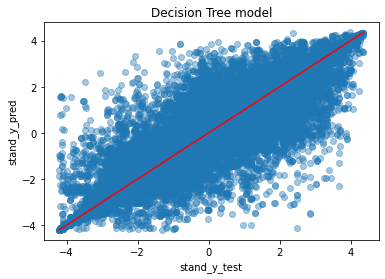

In [87]:
clf_y_predict = model_clf.predict(test_x)
plt.scatter(test_y,clf_y_predict, alpha=0.4)
line = np.linspace(min(test_y.values), max(test_y.values), 1000)
plt.plot(line, line, color = 'r')
plt.title("Decision Tree model")
plt.xlabel('stand_y_test')
plt.ylabel('stand_y_pred')
plt.show()


- 산점도 역시 비교분석하기 힘들지만 선형 회귀모델에 비해 비교적 회귀직선에 수렴한 분포를 확인할 수 있었다.
- 히스토그램을 통해 보다 자세하게 분석

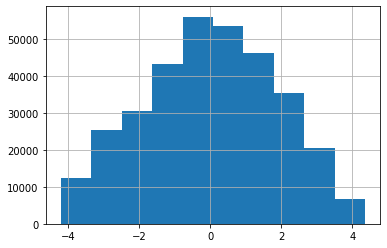

In [88]:
test_y.hist()

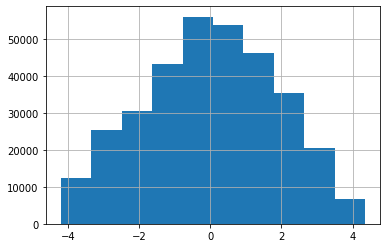

In [89]:
pd.Series(clf_y_predict).hist()

- 실제값과 거의 동일한 분포의 값들이 산출
- Decision Tree만으로도 충분히 의미있는 결과값 산출을 할 수 있다.
- 앙상블 모델로 accuracy 0.01라도 끌어올릴 수 있다면?
- 추가 분석 진행

In [90]:
clf_mse = mean_squared_error(test_y, clf_y_predict)
clf_rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(clf_mse,clf_rmse))
print('Variance score : {0:.3f}'.format(r2_score(test_y,clf_y_predict)))
print('R2 score : {0:.3f}'.format(model_clf.score(train_x, train_y)))

MSE : 0.092, RMSE : 1.044
Variance score : 0.974
R2 score : 1.000


### RandomForest model 사용

In [91]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
start = time.time()
rf = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model_rf = rf.fit(train_x,train_y)
print("Randomforest model time : ", time.time() - start)

Randomforest model time :  650.4035069942474


- 훈련 시간만 무려 10분 30초를 잡아먹는다.   
- 정말 accuracy 향상을 위한게 아니면 그다지 추천하는 작업은 아닐 것 같다.   
- 후에 lightgbm모델도 비슷할 것으로 추측

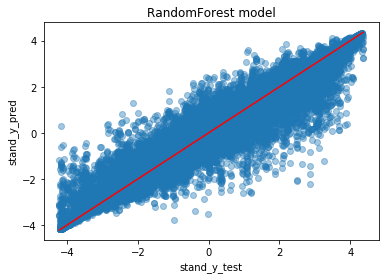

In [ ]:
rf_y_predict = model_rf.predict(test_x)
plt.scatter(test_y,rf_y_predict, alpha=0.4)
line = np.linspace(min(test_y.values), max(test_y.values), 1000)
plt.plot(line, line, color = 'r')
plt.title("RandomForest model")
plt.xlabel('stand_y_test')
plt.ylabel('stand_y_pred')
plt.show()

- Decision Tree에 비해 훈련시간은 길지만 분산이 줄어듬을 확인함.
- 0.01의 accuracy라도 올리는데 효과가 있음을 확인함.

In [ ]:
rf_mse = mean_squared_error(test_y, rf_y_predict)
rf_rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(rf_mse,rf_rmse))
print('Variance score : {0:.3f}'.format(r2_score(test_y,rf_y_predict)))
print('R2 score : {0:.3f}'.format(model_rf.score(train_x, train_y)))

MSE : 0.045, RMSE : 1.044
Variance score : 0.987
R2 score : 0.998


Feature: 0, Score : 0.08328
Feature: 1, Score : 0.54622
Feature: 2, Score : 0.08120
Feature: 3, Score : 0.03081
Feature: 4, Score : 0.02769
Feature: 5, Score : 0.18446
Feature: 6, Score : 0.04636


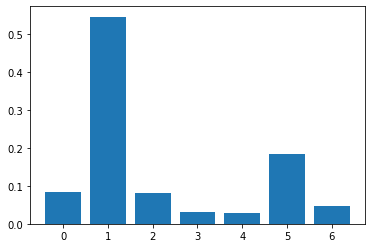

In [ ]:
from matplotlib import pyplot
importance = model_rf.feature_importances_

for i,v in enumerate(importance):
  print('Feature: %0d, Score : %.5f'%(i,v))
pyplot.bar([x for x in range(len(importance))],importance)
pyplot.show()

In [ ]:
train_x.columns

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'x_PCA'], dtype='object')

- 0.974에서 0.987로 Variance score가 올라감을 확인함
- MSE 또한 0.092에서 0.045로 감소함
- 미세한 성능향상이지만 상위권에서 성능향상이므로 의미있는 분석
- randomforest Regressor의 경우 feature_importance 출력하는 방식이 lightgbm 모델과 차이가 있음.. rf의 경우 coolant와 i_d를 주요인자로 뽑음

### Lightgbm model 사용

In [ ]:
import lightgbm as lgb

train_ds = lgb.Dataset(train_x,label = train_y)
test_ds = lgb.Dataset(test_x,label = test_y)

In [ ]:
params = {'n_estimators' : 2000,
          'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [ ]:
start = time.time()
model_lgb = lgb.train(params, train_ds, 10000, test_ds, verbose_eval=100, early_stopping_rounds=100)
print("lightgbm model time : ", time.time() - start)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.956801
[200]	valid_0's l2: 0.510495
[300]	valid_0's l2: 0.392026
[400]	valid_0's l2: 0.337698
[500]	valid_0's l2: 0.304146
[600]	valid_0's l2: 0.28072
[700]	valid_0's l2: 0.263127
[800]	valid_0's l2: 0.25027
[900]	valid_0's l2: 0.240046
[1000]	valid_0's l2: 0.230989
[1100]	valid_0's l2: 0.222932
[1200]	valid_0's l2: 0.215848
[1300]	valid_0's l2: 0.208884
[1400]	valid_0's l2: 0.202263
[1500]	valid_0's l2: 0.196094
[1600]	valid_0's l2: 0.190777
[1700]	valid_0's l2: 0.186163
[1800]	valid_0's l2: 0.181206
[1900]	valid_0's l2: 0.177175
[2000]	valid_0's l2: 0.173362
[2100]	valid_0's l2: 0.169393
[2200]	valid_0's l2: 0.166151
[2300]	valid_0's l2: 0.162782
[2400]	valid_0's l2: 0.159693
[2500]	valid_0's l2: 0.156347
[2600]	valid_0's l2: 0.153777
[2700]	valid_0's l2: 0.151201
[2800]	valid_0's l2: 0.14887
[2900]	valid_0's l2: 0.146683
[3000]	valid_0's l2: 0.144248
[3100]	valid_0's l2: 0.142031
[3200]	valid_0's l2:

* Feature importance

>   * 하나의 decision tree에서 각각의 attribute로 이루어진 split point에 의해 얼마나 트리의 성능이 올라가는지를 계산함.  
>   * instance가 split point에 의해 영향을 받는지 숫자만큼 가중치를 두어 성능 향상치를 계산함.   
>   * 앙상블 모델(RF)은 모든 decision tree에 대해 구하고 평균을 냄.   
>   * 성능 측정은 지니계수 또는 information gain을 사용

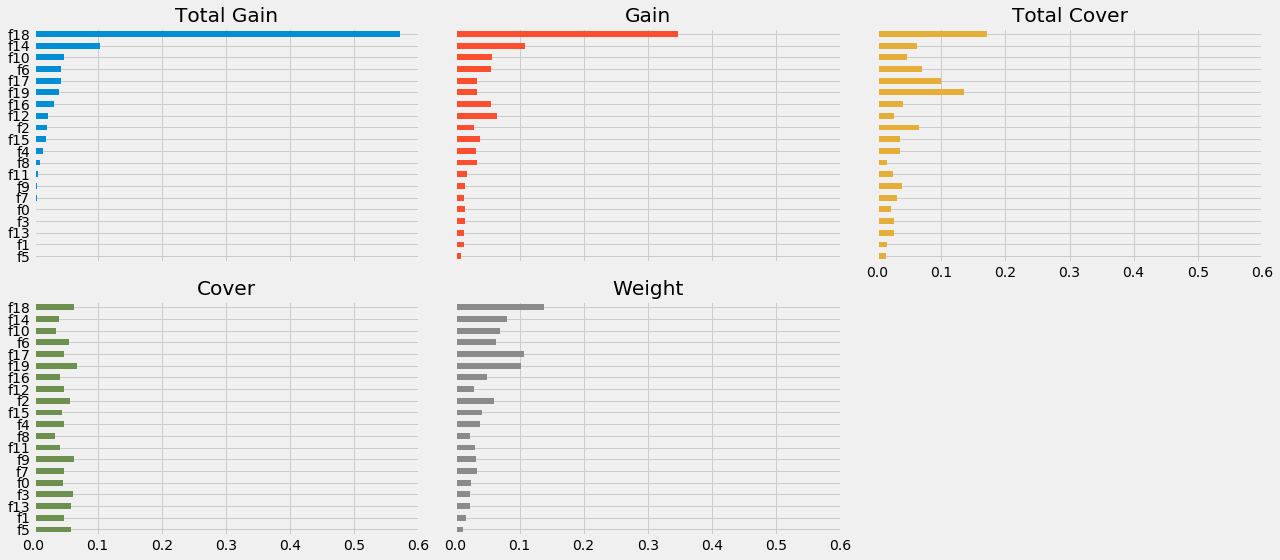   
<< Feature importance 원리 >>

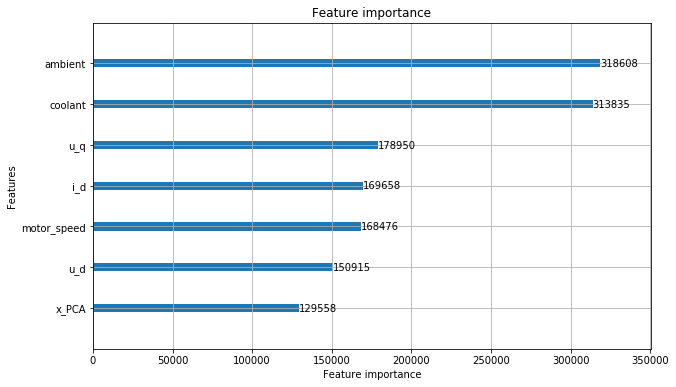

In [ ]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance
fig,ax = plt.subplots(figsize = (10,6))
plot_importance(model_lgb,ax=ax)

In [ ]:
lgb_y_predict_train = model_lgb.predict(train_x)
lgb_y_predict_test = model_lgb.predict(test_x)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

lgb_mse = mean_squared_error(test_y, lgb_y_predict_test)
lgb_r2 = r2_score(test_y, lgb_y_predict_test)

In [ ]:
print('lightgbm Mean squared error: ', lgb_mse)
print('lightgbm Variance score : {0:.3f}'.format(r2_score(test_y,lgb_y_predict_test)))
print('lightgbm R2 score: ', lgb_r2)

lightgbm Mean squared error:  0.08359312604142896
lightgbm Variance score : 0.976
lightgbm R2 score:  0.9758868781650939


In [ ]:
final_result = pd.concat([test_y.reset_index(drop=True), pd.DataFrame(lgb_y_predict_test)], axis = 1)

In [ ]:
final_result.columns = ['test_y','predict']

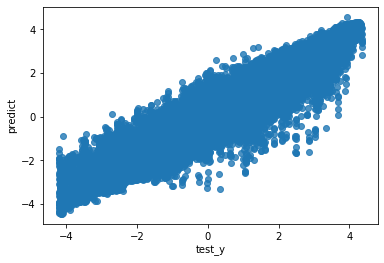

In [ ]:
import seaborn as sns
sns.regplot(x = 'test_y', y = 'predict', data = final_result)

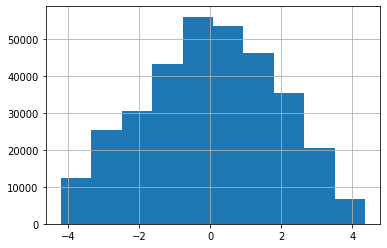

In [ ]:
test_y.hist()

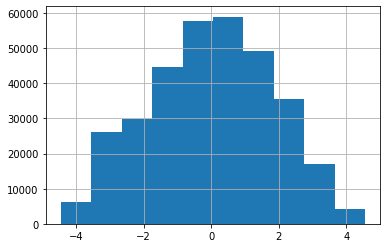

In [ ]:
pd.Series(lgb_y_predict_test).hist()

### MLP model 사용

In [ ]:
train_x

,ambient,coolant,u_d,u_q,motor_speed,i_d,x_PCA
339259,-0.220472,-0.180476,-0.403790,1.546530,0.941941,-0.112864,-0.095223
327317,-0.459517,0.377016,0.315849,-1.330556,-1.222431,1.029147,0.349897
369436,-0.139411,0.323597,1.177675,0.139803,-0.348314,0.570178,1.917082
797124,-1.022138,-0.355820,0.848799,-0.518742,-0.729976,0.473903,2.150307
498,-0.802005,-1.054030,0.183145,1.676523,2.024118,-0.818369,0.362874
...,...,...,...,...,...,...,...
192476,-1.212341,-1.076090,0.286822,-1.168538,-1.189990,0.924248,-0.320327
17730,-0.581731,-1.057742,-0.955778,0.646803,-0.140251,0.386204,-1.530400
28030,0.074134,-1.094394,0.310154,-0.707684,-0.951874,1.029142,0.349658
277869,-2.749614,-1.090646,0.167840,0.403517,-0.410789,1.013982,0.144918


In [ ]:
train_y

339259   -0.560281
327317   -1.505569
369436    0.500476
797124   -2.812158
498      -2.305082
            ...   
192476   -2.067085
17730    -2.270284
28030    -3.230032
277869   -2.842089
773630   -1.056901
Name: y_PCA1, Length: 668706, dtype: float64

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes = (256,16),max_iter=50)

In [ ]:
start = time.time()

mlp.fit(train_x,train_y)
mlp_predict = mlp.predict(test_x)
print("MLP model time : ", time.time() - start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP model time :  452.7616217136383


In [ ]:
mlp_mse = mean_squared_error(test_y, mlp_predict)
mlp_r2 = r2_score(test_y, mlp_predict)
print('MLP Mean squared error: ', mlp_mse)
print('MLP Variance score : {0:.3f}'.format(r2_score(test_y,mlp_predict)))
print('MLP R2 score: ', mlp_r2)

MLP Mean squared error:  0.32761306112755306
MLP Variance score : 0.905
MLP R2 score:  0.9054973293646171


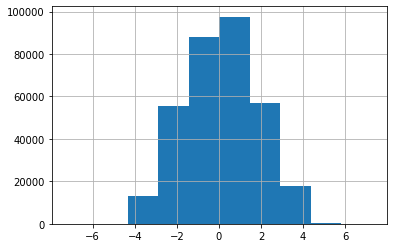

In [ ]:
pd.Series(mlp_predict).hist()

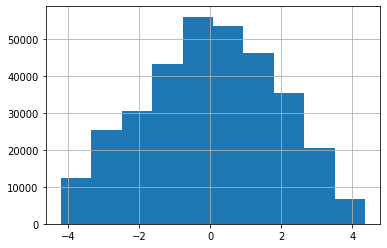

In [ ]:
test_y.hist()

- 여러 실험을 진행했으나, layer가 깊으면 좋은 결과를 배출하긴 함
- 하지만 기하급수적으로 계산시간이 증가함 (레이어 4개, 최대 5470초 소요)
- 빈도가 높은 값들은 잘 맞추나, 빈도가 낮은 값들은 맞추지 못함

## 실험결과 요약

* linear regression model   
MSE : 1.090, RMSE : 1.044   
Variance score : 0.685   
R2 score : 0.687   

* Decision tree model   
MSE : 0.091, RMSE : 1.044   
Variance score : 0.974   
R2 score : 1.000   
Decision Tree model time :  13.966539144515991   

* Random Forest model   
MSE : 0.045, RMSE : 1.044   
Variance score : 0.987   
R2 score : 0.998   
Randomforest model time :  631.9166750907898   

* lightgbm model    
mse:  0.08   
R2 score:  0.96   
lightgbm model time :  590.7603940963745

* MLP model   
mse:  0.31414954216636365   
R2 score:  0.91   
MLP model time :  637.8875794410706

### 실험결과

- 데이터 셋 소개에서 주요 변수로 삼았던 PM , stator_yoke, stator_tooth, stator_winding과는 달리 ambient(모터 주변온도), coolant(냉각수 온도) 또한 주요한 변수로 선정
- 종속 변수와 같이 온도라는 도메인에서 높은 점수를 얻었다고 추정.
